# WORK IN PROGRESS 
# Scrape and analyze data from lebensmittelwarnung.de

In [1]:
import requests
import json
import time
import pandas as pd
from bs4 import BeautifulSoup

import matplotlib.pyplot as plt

In [2]:
domain = "https://www.lebensmittelwarnung.de"
entries = 1000000 #no of entries you want to scrape. Set an unreasonable high number to get all possible results
url = f"{domain}/bvl-lmw-de/liste/lebensmittel/deutschlandweit/{entries}/0" #url to scrape

## Get the data from the website

In [3]:
results = requests.get(url).text
DOMdocument = BeautifulSoup(results, "html.parser")

In [88]:
warnings = []
for warning in DOMdocument.find_all('div','lmw-warnungsliste'): #iterate through all listed warnings and store data to list
    try:
        warningtype = warning.find('div','warnungstyp').text.replace('\n',' ').replace("Warnungstyp:",'')
    except:
        warningtype = ''
    
    try:
        producer = warning.find('div','hersteller').text.replace('\n',' ').replace('Hersteller','').replace('Inverkehrbringer','').replace(':','').replace('(','').replace(')','')
    except:
        producer = ''
    
    try:
        product = warning.find('div','produktbezeichnung').text.replace('\n','').replace('Produktbezeichnung:','')
    except:
        product = ''
    
    try: 
        date = warning.find('div','datum').text.replace('\n','').replace('Datum:','')
    except:
        date = ''
    
    try: 
        thumbnail = domain + warning.find('div','produktbild').find('img')["src"]
    except:
        thumbnail = ''
    
    try: 
        source = warning.find('div','quelle').text.replace('\n','').replace('Quelle:','')
    except:
        source = ''
        
    try: 
        reason = warning.find('div','grundderwarnung').text.replace('\n','').replace('Grund der Warnung:','')
    except:
        reason = ''
    
    try: 
        state = warning.find('div','betroffeneLaender').text.replace('\n','').replace('betroffene Länder (alphabetisch):','')
    except:
        state = ''
    
    try: 
        detail_link = domain + warning.find("div","detailsButton").find("a")["href"]
    except:
        detail_link = ''
    
    warnings.append([warningtype,date,producer,product,reason,state,source,thumbnail,detail_link])
    

## Store the data as a csv for later use

In [89]:
df = pd.DataFrame(warnings,columns=["warningtype","date","producer","product","reason","state","source","thumbnail","detail_link"])
df.to_csv('lebensmittelwarnungen.csv',index=False)

## Analyze the data

### Most common warning reasons
Lets analyse the reasons for which products are being called back.

In [90]:
data = df.copy()#create a copy of the dataframe that can be manipulated in the further exploration process
data.head()

,warningtype,date,producer,product,reason,state,source,thumbnail,detail_link
0,Lebensmittel,13.04.2022,Firma Fromagerie Jacquin,Selles sur Cher,Verdacht auf Kontamination mit unerwünschten B...,"Bayern, Berlin, Nordrhein-Westfalen, Sachsen",,https://www.lebensmittelwarnung.de/bvl-lmw-de/...,https://www.lebensmittelwarnung.de/bvl-lmw-de/...
1,Lebensmittel,12.04.2022,Jentschura International GmbH Otto-Hahn-...,WurzelKraftPflanzliches Feingranulat zum Verze...,Nachweis von Salmonellen,"Baden-Württemberg, Bayern, Berlin, Hessen, Nie...",Jentschura International GmbH,https://www.lebensmittelwarnung.de/bvl-lmw-de/...,https://www.lebensmittelwarnung.de/bvl-lmw-de/...
2,Lebensmittel,08.04.2022,Ferrero Deutschland GmbH Hainer Weg 120 60...,Erneute Ausweitung des Rückrufes von diversen ...,Die genannten Produkte stehen in einem mutmaßl...,"Baden-Württemberg, Bayern, Berlin, Brandenburg...",Ferrero Deutschland GmbH,https://www.lebensmittelwarnung.de/bvl-lmw-de/...,https://www.lebensmittelwarnung.de/bvl-lmw-de/...
3,Lebensmittel,07.04.2022,Ferrero Deutschland GmbH\r Hainer Weg 120\...,Erneute Ausweitung des Rückrufes von diversen ...,Die genannten Produkte stehen in einem möglich...,"Baden-Württemberg, Bayern, Berlin, Brandenburg...",Ferrero Deutschland GmbH,https://www.lebensmittelwarnung.de/bvl-lmw-de/...,https://www.lebensmittelwarnung.de/bvl-lmw-de/...
4,Lebensmittel,06.04.2022,Ferrero Deutschland GmbH\r Hainer Weg 120\...,Ausweitung des Rückrufes von diversen Schokola...,Die genannten Produkte stehen in einem möglich...,"Baden-Württemberg, Bayern, Berlin, Brandenburg...",Ferrero Deutschland GmbH,https://www.lebensmittelwarnung.de/bvl-lmw-de/...,https://www.lebensmittelwarnung.de/bvl-lmw-de/...


In [91]:
data.reason.value_counts()

Salmonellen                                                                                                                        11
Ethylenoxid                                                                                                                         8
Grenzüberschreitung bzgl. Ethylenoxid                                                                                               5
Der festgestellte Ethylenoxid-Gehalt liegt über dem zugelassenen Grenzwert.                                                         4
Ethylenoxid oberhalb der zulässigen Höchstmengen nachgewiesen                                                                       4
                                                                                                                                   ..
Mögliche Lackablösungen im Inneren der Konservendosen                                                                               1
Es ist nicht mit absoluter Sicherheit auszuschließen, dass im 

At first glance, salmonella seem to be the most common reason but Ethylenoxid is in second place and with a differing title also in third place. We will thus have to identify if there are any reasons that occur with multiple different spellings. Create a list of common categories to categorize each entry.

In [92]:
data.reason.unique()

array(['Verdacht auf Kontamination mit unerwünschten Bakterien Listeria Monocytogenes.',
       'Nachweis von Salmonellen',
       'Die genannten Produkte stehen in einem mutmaßlichen Zusammenhang mit einem Salmonellen-Ausbruchsgeschehen',
       'Die genannten Produkte stehen in einem möglichen Zusammenhang mit einem Salmonellen-Ausbruchsgeschehen.',
       'nicht deklariertes Milcheiweiß',
       'Eigenuntersuchungen haben gezeigt, dass das Produkt Salmonellen aufweisen kann',
       'nicht deklariertes Allergen Sulfit',
       'Fehlende Kennzeichnung des allergenen Zusatzstoffes Schwefeldioxid',
       'Belastung mit Ethylenoxid',
       'Aufgrund eines Etikettierungsfehlers auf dem Becher-Boden und auf der Becher-Seite kann bei einzelnen Produkten mit der Deckel-Etikettierung Garnelensalat mit Cocktail-Creme (125 g) der Marke NADLER die Ausweisung der Allergene Garnelen, Sahne und Natriummetabisulfit und die Spurenhinweise für Fisch, Soja, Sellerie, Sesam und Gluten fehlen.',
     

In [93]:
common_reasons = [
    "Salmonellen",
    "Chlorpyrifos",
    "Fälschung",
    "Glas",
    "Ethylenoxid",
    "Allergen",
    "Allergiker",
    "Fremdkörper",
    "Schimmel",
    "Johannisbrotkernmehl",
    "Schimmel",
    "Plastik",
    "Aflatoxin",
    "Metall",
    "Jod",
    "Blei",
    "Nüsse",
    "Sellerie",
    "Pyrrolizidinalkaloid",
    "THC",
    "Allergen",
    "Plastik"
]

Now, high values of Ethylenoxid seems to be the most common reason, followed by glas particles and salmonella

Let's append the reason categories and the countries as individual one-hot encoded features to our dataset

In [94]:
for reason in common_reasons:
    data['reason_' +  reason] = data["reason"].apply(lambda x: True if reason.lower() in str(x).lower() else False)

In [95]:
#create a list with all possible states (Bundesländer)
statelist = []
for states in data.state:
    for state in states.split(','):
        statelist.append(state.strip()) 
statelist = set(statelist)

In [96]:
#one-hot encode the possible states and append a column with each state to the dataframe
for state in statelist:
    data['state_' + state] = data["state"].apply(lambda x: True if state in [word.strip() for word in x.split(',')] else False)

Now, the dataframe contains a one-hot encoded column for each major reason category and for each state. This will make plotting and analysis much easier than having this data nested in lists within columns.

In [97]:
#look at exemplary one-hot encoded data for state=Berlin and reason=Salmonellen
data[["state","state_Berlin","reason_Salmonellen"]]

,state,state_Berlin,reason_Salmonellen
0,"Bayern, Berlin, Nordrhein-Westfalen, Sachsen",True,False
1,"Baden-Württemberg, Bayern, Berlin, Hessen, Nie...",True,True
2,"Baden-Württemberg, Bayern, Berlin, Brandenburg...",True,True
3,"Baden-Württemberg, Bayern, Berlin, Brandenburg...",True,True
4,"Baden-Württemberg, Bayern, Berlin, Brandenburg...",True,True
...,...,...,...
244,"Baden-Württemberg, Bayern, Berlin, Brandenburg...",True,False
245,"Baden-Württemberg, Bayern, Hessen, Niedersachs...",False,False
246,"Baden-Württemberg, Bayern, Berlin, Brandenburg...",True,False
247,"Bayern, Hamburg, Niedersachsen, Nordrhein-West...",False,False


### Data Visualization
Now let's start visualizing the data to find out, which reasons are the most common for which producers in which German regions.

Plotting how often a region is mentioned shows us that the state mentioned most often (NRW) is mentioned 30% more often than the least mentioned state (Mecklenburg-Vorpommern).

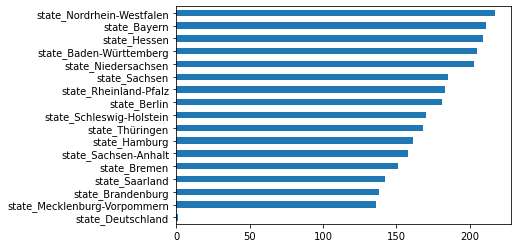

In [110]:
data[['state_' + region for region in statelist]].sum().sort_values().plot(kind='barh')

['state_Berlin',
 'state_Sachsen',
 'state_Schleswig-Holstein',
 'state_Hamburg',
 'state_Thüringen',
 'state_Baden-Württemberg',
 'state_Hessen',
 'state_Sachsen-Anhalt',
 'state_Rheinland-Pfalz',
 'state_Nordrhein-Westfalen',
 'state_Bremen',
 'state_Niedersachsen',
 'state_Bayern',
 'state_Saarland',
 'state_Mecklenburg-Vorpommern',
 'state_Brandenburg',
 'state_Deutschland']